## Movies Reviews Text Based Analysis & Classification Project
ADS509 - Team 3 - Final Group Project<p>
Jacqueline Vo, Connie Chow<p>
October 23, 2023

### Load the Movie Reviews Data

In [171]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import emoji
from string import punctuation
from collections import Counter
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pyLDAvis.lda_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Install packages if needed
#spacy.cli.download('en_core_web_sm')
#nlp = spacy.load('en_core_web_sm')

In [172]:
# Define the URL
url = "https://raw.githubusercontent.com/jvo024/ads509-movie-scrape/main/datasets/all_tmbd_rt_data.csv"

# Read data from the URL into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame (optional)
df.head()

,movie_title,review_rating,review_content,sentiment
0,Blue Beetle,7.0,MORE SPOILER-FREE MINI-REVIEWS @ https://www.m...,good
1,Blue Beetle,6.0,"Maybe this should just have been called the ""B...",good
2,Blue Beetle,7.0,Blue beetle is very awesome!! WoW!👏🏻👏🏻👍🏻👍🏻,good
3,Blue Beetle,6.0,The Good: Light-hearted and family centric. Lo...,good
4,Meg 2: The Trench,5.0,"Now the ""Meg"" (2018) itself could never be cal...",good


### Text Data Preprocessing

In [177]:
from nltk.corpus import stopwords
from collections import Counter

# Constants
PUNCTUATION = set(punctuation)
STOPWORDS = set(stopwords.words("english"))

def descriptive_stats(tokens, top_tokens=10, verbose=True):
    """
    Calculate descriptive statistics for a list of tokens.
    Args:
        tokens (list): List of tokens.
        top_tokens (int): Number of top tokens to display.
        verbose (bool): Print statistics if True.
    Returns:
        list: A list containing [num_tokens, num_unique_tokens, lexical_diversity, num_characters]
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    token_counter = Counter(tokens)
    most_common_tokens = token_counter.most_common(top_tokens)

    if verbose:
        print(f"Number of tokens: {num_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.3f}")
        print(f"Most common tokens (Top {top_tokens}):")
        for token, count in most_common_tokens:
            print(f" - {token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

def remove_hyperlink(text):
    """
    Remove hyperlinks from text using regular expressions.
    """
    hyperlink_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    cleaned_text = re.sub(hyperlink_pattern, '', text)
    return cleaned_text

def remove_stop(tokens):
    """
    Remove stopwords from a list of tokens.
    """
    removed_tokens = [token for token in tokens if token.lower() not in STOPWORDS and token != 'nan']
    return removed_tokens

def remove_numerical(tokens):
    """
    Remove tokens that are purely numerical.
    """
    cleaned_tokens = [token for token in tokens if not re.match(r'^[0-9.]+$', token)]
    return cleaned_tokens

def remove_punctuation(text):
    """
    Remove punctuation from text.
    """
    if text == 'nan':
        return ''  # Remove 'nan'

    PUNCTUATION.add("'")
    return "".join([ch for ch in text if ch not in PUNCTUATION])

def tokenize(text):
    """
    Tokenize text.
    """
    return word_tokenize(text)

def prepare(text, pipeline):
    """
    Apply a list of text processing transformations to a text.
    """
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


whitespace_pattern = re.compile(r"\s+")
all_language_emojis = set()

for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)


In [178]:
pipeline = [remove_hyperlink, str.lower, remove_punctuation, tokenize, remove_stop, remove_numerical]

df["tokens"] = df["review_content"].apply(prepare, pipeline=pipeline)
df["num_tokens"] = df["tokens"].map(len)
df.head()

,movie_title,review_rating,review_content,sentiment,tokens,num_tokens
0,Blue Beetle,7.0,MORE SPOILER-FREE MINI-REVIEWS @ https://www.m...,good,"[spoilerfree, minireviews, blue, beetle, follo...",82
1,Blue Beetle,6.0,"Maybe this should just have been called the ""B...",good,"[maybe, called, blue, bottle, annoying, blowfl...",185
2,Blue Beetle,7.0,Blue beetle is very awesome!! WoW!👏🏻👏🏻👍🏻👍🏻,good,"[blue, beetle, awesome, wow👏🏻👏🏻👍🏻👍🏻]",4
3,Blue Beetle,6.0,The Good: Light-hearted and family centric. Lo...,good,"[good, lighthearted, family, centric, love, st...",24
4,Meg 2: The Trench,5.0,"Now the ""Meg"" (2018) itself could never be cal...",good,"[meg, could, never, called, good, film, great,...",212


### Exploratory Data Analysis

#### Descriptive Statistics for Good and Bad Reviews

In [179]:
# Pre-processing split to view dataset in good/bad
good_df = df[df['sentiment'] == 'good']
bad_df = df[df['sentiment'] == 'bad']

# Combine all tokens
good_tokens = good_df["tokens"].sum()
bad_tokens = bad_df["tokens"].sum()

In [180]:
# Use descriptive stats function on both datasets
# Still not sure why single quotation mark is included as a top token for both good/bad
print(f"--- Good Reviews ---")
good_stats = descriptive_stats(good_tokens)
print(f"--- Bad Reviews ---")
bad_stats = descriptive_stats(bad_tokens)

--- Good Reviews ---
Number of tokens: 872782
Number of unique tokens: 49752
Number of characters: 5303945
Lexical diversity: 0.057
Most common tokens (Top 10):
 - film: 10464
 - movie: 8814
 - ’: 7549
 - one: 6790
 - like: 4857
 - story: 4770
 - good: 4330
 - well: 3836
 - really: 3708
 - time: 3544
--- Bad Reviews ---
Number of tokens: 132379
Number of unique tokens: 18338
Number of characters: 792191
Lexical diversity: 0.139
Most common tokens (Top 10):
 - movie: 1830
 - film: 1563
 - ’: 1427
 - one: 1046
 - like: 1030
 - even: 745
 - good: 695
 - really: 606
 - story: 565
 - much: 546


#### Token Concentration

In [181]:
from collections import Counter

# Count total number of tokens for both dataframes
total_good = good_stats[0]
total_bad = bad_stats[0]

token_counts_good = Counter(good_tokens)
token_counts_bad = Counter(bad_tokens)

good_df = pd.DataFrame(token_counts_good.items(), columns=["token", "good_tokens"])
bad_df = pd.DataFrame(token_counts_bad.items(), columns=["token", "bad_tokens"])

# Calculate the concentration for good_tokens
good_df["good concentration"] = good_df.apply(lambda row: row["good_tokens"] / total_good, axis=1)

# Calculate the concentration for bad_tokens
bad_df["bad concentration"] = bad_df.apply(lambda row: row["bad_tokens"] / total_bad, axis=1)

calc_df = [good_df, bad_df]

group_df = calc_df[0]
for calc_df in calc_df[1:]:
    group_df = pd.merge(group_df, calc_df, on="token", how="inner")

cutoff = 10

def check_cutoff(column):

    return (column['good_tokens'] + column['bad_tokens']) > cutoff


group_df['cutoff'] = group_df.apply(check_cutoff, axis=1)
group_df['ratio'] = (group_df["good concentration"])/(group_df["bad concentration"])
sorted_group = group_df.sort_values(by="ratio", ascending=False)
top_group = sorted_group.head(10)
# Creates top tokens for both good/bad
top_group.head()

,token,good_tokens,good concentration,bad_tokens,bad concentration,cutoff,ratio
3463,wonderfully,134,0.000154,1,0.000008,True,20.324418
137,denouement,87,0.000100,1,0.000008,True,13.195704
2836,ups,76,0.000087,1,0.000008,True,11.527282
5671,treasure,75,0.000086,1,0.000008,True,11.375607
2814,elevates,73,0.000084,1,0.000008,True,11.072257


#### Word Clouds: Tokens from Bad Reviews Word Cloud & Good Review Word Cloud

In [182]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words(df, column='token', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

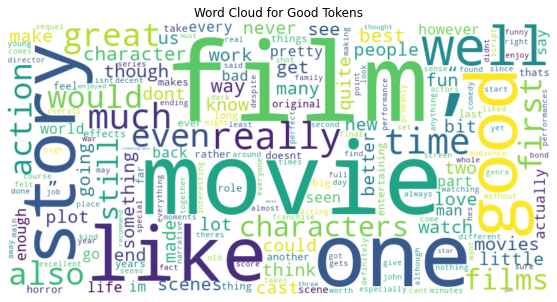

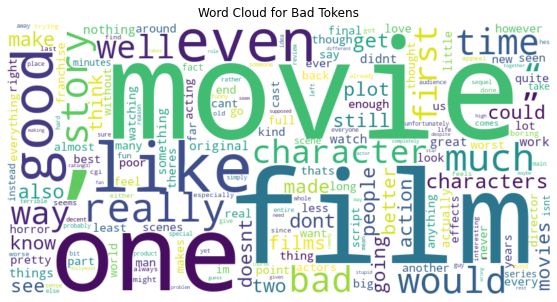

In [183]:
def generate_wordcloud(tokens, title):

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tokens)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create word clouds for good_tokens and bad_tokens
good_word_counts = Counter(good_tokens)
bad_word_counts = Counter(bad_tokens)

generate_wordcloud(good_word_counts, "Word Cloud for Good Tokens")
generate_wordcloud(bad_word_counts, "Word Cloud for Bad Tokens")

#### The most common one word, two word or three word phrases

<AxesSubplot:title={'center':'Bar chart of Bigrams Frequency'}, xlabel='Bigram Words', ylabel='Count'>

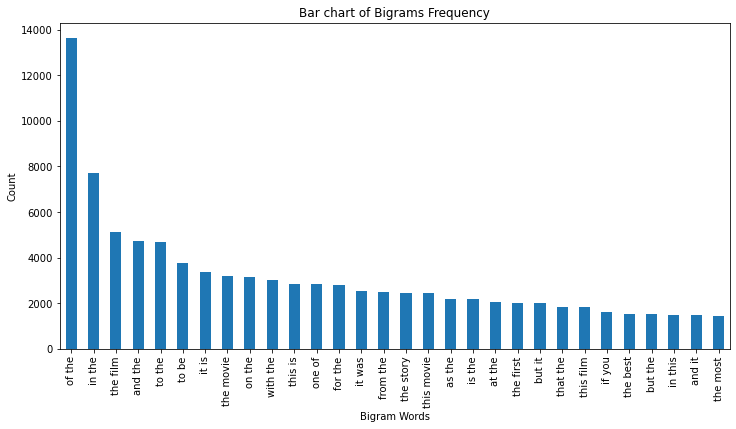

In [184]:
def get_top_n_bigram(corpus, n=None):

    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['review_content'], 30)
df2 = pd.DataFrame(common_words, columns=['Text', "Count"])

df2.groupby('Text').sum()['Count'].sort_values(ascending=False).plot(
kind='bar',
figsize=(12,6),
xlabel = "Bigram Words",
ylabel = "Count",
title = "Bar chart of Bigrams Frequency"
)

### Train Test Split Dataset

In [185]:
# good_df = df[df['sentiment'] == 'good']
# bad_df = df[df['sentiment'] == 'bad']
#
# # Determine which df is smaller, use that size as the basis for forming the training set
# num_good_rows = len(good_df)
# num_bad_rows = len(bad_df)
# min_num_rows = min(num_good_rows, num_bad_rows)
#
# # Also assign 1 and 0 binary for good or bad movie reviews to train model
# if num_good_rows < num_bad_rows:
#     temp_df = good_df.sample(n=min_num_rows, random_state=42)  # Randomly sample from bad_df
#     X = pd.concat([temp_df, bad_df])
#     X = X.reset_index(drop=True)
#     y = X['sentiment']
#     y = y.map({"good": 1, "bad": 0})
# else:
#     temp_df = bad_df.sample(n=min_num_rows, random_state=42)  # Randomly sample from bad_df
#     X = pd.concat([good_df, temp_df])
#     X = X.reset_index(drop=True)
#     y = X['sentiment']
#     y = y.map({"good": 1, "bad": 0})
#
#
# # split the data 80/20 ratio
# X = X[['review_content']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Sentiment' column
training_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])
"""

"\nfrom sklearn.preprocessing import LabelEncoder\n# Initialize the LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Fit and transform the 'Sentiment' column\ntraining_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])\n"

### Modeling & Evaluation

#### Naive Bayes Model

In [186]:
movie_reviews = df[['tokens', 'sentiment']].values.tolist()

In [187]:
word_cutoff = 10

tokens = [word for text, _ in movie_reviews for word in text]

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 10, we have 9723 as features in the model.


In [188]:
def conv_features(text,fw) :
    """This function takes in the movie review text and list of
    feature words (from above) and marks each word in the review
    as either existing in the feature word list as True or False
    This will be fed as training data to the classifier
    """

    ret_dict = dict()

    words = text.split()
   
    # Iterate through the words in the text
    for word in words:
        # Check if the word is in the list of words fw
        if word in fw:
            # If it is in fw, set its value to True in the features dictionary
            ret_dict[word] = True
            
    return {k: v for k, v in ret_dict.items() if v}
    
    return(ret_dict)

In [189]:
featuresets = [(conv_features(' '.join(tokens), feature_words), sentiment)
               for (tokens, sentiment) in movie_reviews]

In [190]:
# Train the Naive Bayes Classifier
test_size = 500
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Accuracy Score: ", nltk.classify.accuracy(classifier, test_set))

Accuracy Score:  0.88


In [191]:
# Get the most informative features (tokens)
classifier.show_most_informative_features(25)

Most Informative Features
                 dumbest = True              bad : good   =     18.3 : 1.0
                 unfunny = True              bad : good   =     15.5 : 1.0
             wonderfully = True             good : bad    =     14.9 : 1.0
                simpsons = True              bad : good   =     13.0 : 1.0
                   velma = True              bad : good   =     13.0 : 1.0
               homicidal = True              bad : good   =     12.2 : 1.0
                finished = True              bad : good   =     12.1 : 1.0
              amateurish = True              bad : good   =     10.6 : 1.0
                 hercule = True              bad : good   =     10.0 : 1.0
                  drivel = True              bad : good   =      9.3 : 1.0
                   pills = True              bad : good   =      9.3 : 1.0
              denouement = True             good : bad    =      9.2 : 1.0
                    quit = True              bad : good   =      8.7 : 1.0

#### LinearSVC Model

In [192]:
from sklearn.metrics import accuracy_score

X = df['review_content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

freq_vector = CountVectorizer(stop_words="english")
X_train_freq = freq_vector.fit_transform(X_train)
X_train_freq.shape

# Apply TF-IDF transformation to the CountVectorizer output
tfidf_transf = TfidfTransformer()
X_train_tfidf = tfidf_transf.fit_transform(X_train_freq)
X_train_tfidf.shape

svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

X_test_freq = freq_vector.transform(X_test)
X_test_tfidf = tfidf_transf.transform(X_test_freq)
y_pred = svc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8934331797235023


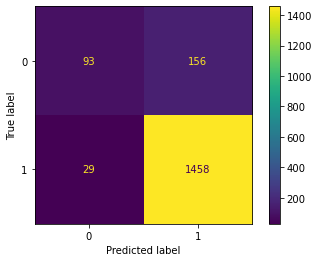

In [193]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

#### Random Forest Classifier Model

In [194]:
# # Transform the Input Text of Training Data using Trained Tfidf Vectorizer
# train_feature_vectors = count_text_vectorizer.transform(X_train)
# #train_feature_vectors = train_feature_vectors.todense()
#
# # Get the name of Features (Feature Set) and create a DataFrame of Input Features
# input_training_features = pd.DataFrame(train_feature_vectors, columns = count_text_vectorizer.get_feature_names())
# input_training_features = input_training_features.round(2)
#
# # Display the Document Feature Matrix of Training Data
# print("Document Features Matrix of Training Data :")
# print("============================================")
# #input_training_features = input_training_features.round(2)
# input_training_features.head()
#
# # Split the Training Data Outputs / Labels and Create a DataFrame
# training_data_output = pd.DataFrame(y_train)
#
# # Output Label Gender of Training Data
# print("Output of Training Data:")
# print("========================")
# training_data_output.head()
#
# from sklearn.preprocessing import LabelEncoder
# # Initialize the LabelEncoder
# label_encoder = LabelEncoder()
#
# # Fit and transform the 'Sentiment' column
# training_data_output['sentiment'] = label_encoder.fit_transform(y_train)
#
# from sklearn.model_selection import train_test_split
#
# X = input_training_features
# y = training_data_output
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
#
# random_forest_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
# random_forest = random_forest_classifier.fit(X_train,np.ravel(y_train))

In [195]:
# # Transform the Input Text of Training Data using Trained Tfidf Vectorizer
# count_vectorizer = CountVectorizer(stop_words = "english")
# count_vectorizer = count_vectorizer.fit(X_train['review_content'])
# train_feature_vectors = count_vectorizer.transform(df_reviews['review_content'])
# train_feature_vectors = train_feature_vectors.todense()
#
# # Get the name of Features (Feature Set) and create a DataFrame of Input Features
# input_training_features = pd.DataFrame(train_feature_vectors, columns = count_vectorizer.get_feature_names())
# input_training_features = input_training_features.round(2)
#
# training_data_output = pd.DataFrame(df_reviews['sentiment'])
# #training_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])
#
# X = input_training_features
# y = training_data_output
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [196]:
# import numpy as np
#
# random_forest_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
# random_forest = random_forest_classifier.fit(X_train,np.ravel(y_train))
#
# print("Parameters and their values:")
# print("============================")
# print(random_forest)

In [197]:
# predictions = text_clf.predict(X_test)

In [198]:
# from sklearn import metrics
# print(metrics.confusion_matrix(y_test, predictions))
# print(metrics.classification_report(y_test, predictions))
# print(metrics.accuracy_score(y_test, predictions))

### Topic Modeling - LSA, LDA, NMT

In [199]:
count_text_vectorizer = CountVectorizer(stop_words=sw, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['review_content'])

tfidf_text_vectorizer = TfidfVectorizer(stop_words=sw, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['review_content'])

In [200]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

def display_topics(model, features, no_top_words=15):

    for topic, words in enumerate(model.components_):

        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [201]:
count_text_vectorizer = CountVectorizer(stop_words=sw, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['review_content'])

tfidf_text_vectorizer = TfidfVectorizer(stop_words=sw, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['review_content'])

#### Non-Negative Matrix Factorization Model

In [202]:
nmf_text_model = NMF(n_components=2, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Topic 00
  film (0.69)
  one (0.35)
  story (0.27)
  well (0.25)
  like (0.25)
  em (0.22)
  time (0.20)
  films (0.20)
  even (0.20)
  much (0.19)
  also (0.18)
  character (0.18)
  characters (0.18)
  first (0.17)
  good (0.17)

Topic 01
  movie (3.24)
  good (1.04)
  really (0.85)
  rating (0.72)
  watch (0.71)
  _final (0.71)
  like (0.67)
  would (0.62)
  movies (0.62)
  lot (0.56)
  recommend (0.56)
  liked (0.54)
  bad (0.51)
  action (0.50)
  pretty (0.47)


#### LSA Model

In [203]:
svd_para_model = TruncatedSVD(n_components=2, random_state=509)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  movie (0.62)
  film (0.52)
  one (0.38)
  good (0.34)
  like (0.34)
  really (0.29)
  story (0.29)
  well (0.26)
  time (0.25)
  action (0.24)
  much (0.22)
  would (0.22)
  great (0.22)
  even (0.21)
  watch (0.21)

Topic 01
  movie (3.10)
  _final (1.09)
  rating (0.91)
  recommend (0.67)
  good (0.60)
  liked (0.55)
  really (0.52)
  watch (0.47)
  lot (0.45)
  movies (0.44)
  give (0.42)
  would (0.38)
  personally (0.38)
  pretty (0.35)
  appeal (0.34)


#### LDA Model

In [204]:
lda_para_model = LatentDirichletAllocation(n_components=2, random_state=509)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics(lda_para_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  film (1.96)
  one (0.88)
  story (0.64)
  movie (0.59)
  well (0.47)
  like (0.45)
  time (0.42)
  even (0.41)
  good (0.40)
  character (0.40)
  also (0.39)
  characters (0.38)
  best (0.36)
  much (0.34)
  films (0.31)

Topic 01
  movie (1.71)
  one (0.82)
  like (0.81)
  film (0.66)
  good (0.66)
  really (0.64)
  action (0.52)
  well (0.51)
  story (0.49)
  time (0.46)
  much (0.46)
  would (0.43)
  even (0.38)
  first (0.37)
  great (0.37)


In [205]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors,
                                         count_text_vectorizer, sort_topics=False)

pyLDAvis.display(lda_display)

In [206]:
from sympy import categories

def most_common_category(df, topic_idx):
    topic_categories = df[df['sentiment'] == unique_categories[topic_idx]]['sentiment']
    return topic_categories.mode().iloc[0]

models = [nmf_text_model, svd_para_model, lda_para_model]

# Get the unique sentiment categories from the dataframe
unique_categories = df['sentiment'].unique()

for model in models:
    matches = {i: most_common_category(df, i) for i in range(model.n_components)}

    for i, matched_category in matches.items():
        print(f"Model: {model.__class__.__name__}, Topic {i} - '{matched_category}'.")

Model: NMF, Topic 0 - 'good'.
Model: NMF, Topic 1 - 'bad'.
Model: TruncatedSVD, Topic 0 - 'good'.
Model: TruncatedSVD, Topic 1 - 'bad'.
Model: LatentDirichletAllocation, Topic 0 - 'good'.
Model: LatentDirichletAllocation, Topic 1 - 'bad'.
